In [1]:
import pandas as pd
import numpy as np

import shap
import os
import sys
import collections
import torch
import matplotlib.pyplot as plt

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from utilities import normalize_data, Dataset

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models as cate_models
import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [113]:
def plot_categorical_feature_values(feature_values, x_test, n_categories):

    split_indices = np.cumsum(n_categories)[:-1]
    
    agg_shap = []
    agg_x_test = []

    # Process each feature values and test instance
    for feature_val, test_instance in zip(feature_values, x_test):
        
        feature_val_split = np.split(feature_val, split_indices)
        test_instance_split = np.split(test_instance, split_indices)
        
        # Sum SHAP values for each category and keep original feature values for color representation
        agg_shap_instance = [np.sum(l) for l in feature_val_split]
        agg_x_test_instance = [np.argmax(l) if n > 1 else l[0] for l, n in zip(test_instance_split, n_categories)]
        
        agg_shap.append(agg_shap_instance)
        agg_x_test.append(agg_x_test_instance)

    # Convert lists to numpy arrays
    agg_shap = np.array(agg_shap)
    agg_x_test = np.array(agg_x_test)

    # Determine the indices of categorical features
    categorical_indices = [i for i, n in enumerate(n_categories) if n > 1]
    
    for cat_index in categorical_indices:
        # Plot SHAP values for each category
        unique_categories = np.unique(agg_x_test[:, cat_index])
        for cat in unique_categories:
            shap_values_cat = agg_shap[agg_x_test[:, cat_index] == cat, cat_index]
            plt.scatter([cat]*len(shap_values_cat), shap_values_cat,s=4, label=f'Category {cat}')

        plt.title(f"Feature: {feature_names[cat_index]}")
        plt.xlabel("Category")
        plt.ylabel("SHAP Value")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()



def plot_feature_values(feature_values, x_test, n_categories):

    split_indices = np.cumsum(n_categories)[:-1]  # Determine split indices based on n_categories
    
    agg_shap = []
    agg_x_test_colors = []

    # Process each feature values and test instance
    for feature_val, test_instance in zip(feature_values, x_test):
        
        feature_val_split = np.split(feature_val, split_indices)
        test_instance_split = np.split(test_instance, split_indices)
        
        # Sum SHAP values for each category and keep original feature values for color representation
        agg_shap_instance = [np.sum(l) for l in feature_val_split]
        agg_x_test_colors_instance = [l[np.argmax(l)] if n > 1 else l[0] for l, n in zip(test_instance_split, n_categories)]
        
        agg_shap.append(agg_shap_instance)
        agg_x_test_colors.append(agg_x_test_colors_instance)

    # Convert lists to numpy arrays
    agg_shap = np.array(agg_shap)
    agg_x_test_colors = np.array(agg_x_test_colors)

    # Determine the indices of the features with highest mean absolute SHAP values
    ind = np.argpartition(np.abs(agg_shap).mean(0), -len(n_categories))[-len(n_categories):]
    
    # Create the feature names with associated mean absolute SHAP values
    ranked_feature_names = [f"{a}: {b:.3f}" for a, b in zip(feature_names[ind], np.abs(agg_shap[:, ind]).mean(0))]

    # Plot the summary
    shap.summary_plot(
        agg_shap[:, ind],
      agg_x_test_colors[:, ind], 
      feature_names=ranked_feature_names,
      show=False
    )

    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('IST3 - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.4, -2.5, "rt-TPA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.4, -2.5, "rt-TPA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)


def plot_feature_values_original(feature_values, x_test):

    feature_num = feature_values.shape[1]
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(3), -feature_num)[-feature_num:]
    
    ranked_feature_names = [
        a + ": " + str(b) for a,b in zip(feature_names_v2[ind], np.abs(feature_values[:, ind]).mean(0).round(3))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=ranked_feature_names,
        title = "IG"
     )


def plot_feature_values_ind(feature_values, x_test, indices):
    
    
    feature_values = feature_values[:, indices]
    x_test = x_test[:, indices]
    names = feature_names_v2[indices]
    print(names)
        
    stroketype_mapping = {
        "stroketype_1.0": "TACI",
        "stroketype_2.0": "PACI",
        "stroketype_3.0": "LACI",
        "stroketype_4.0": "POCI",
        "stroketype_5.0": "Other"

    }
    
    infarct_mapping = {
        "infarct_0.0": "No",
        "infarct_1.0": "Possibly Yes",
        "infarct_2.0": "Definitely Yes"

    }

    names = [stroketype_mapping.get(i) for i in names]

    feature_num = feature_values.shape[1]
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(4), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(np.array(names)[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]
    
    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        title = "IG",
        show=False
     )
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('IST3 - Stroketype', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.4, -2.5, "rt-TPA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.4, -2.5, "rt-TPA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)
    

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train

Index(['infarct_0.0', 'infarct_1.0', 'infarct_2.0'], dtype='object')


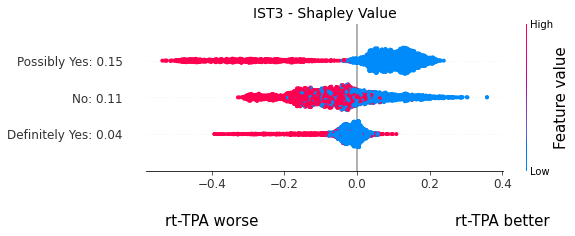

In [112]:
plot_feature_values_ind(baseline_shapley_value, baseline, [10, 11, 12])

Index(['stroketype_1.0', 'stroketype_2.0', 'stroketype_3.0', 'stroketype_4.0',
       'stroketype_5.0'],
      dtype='object')


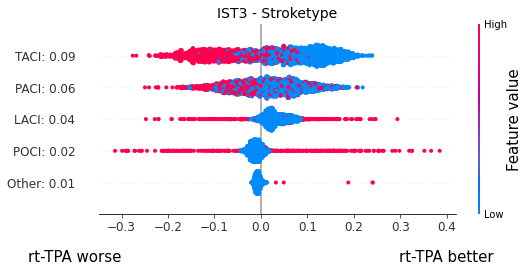

In [114]:
plot_feature_values_ind(baseline_shapley_value, baseline, [13, 14, 15, 16,17])

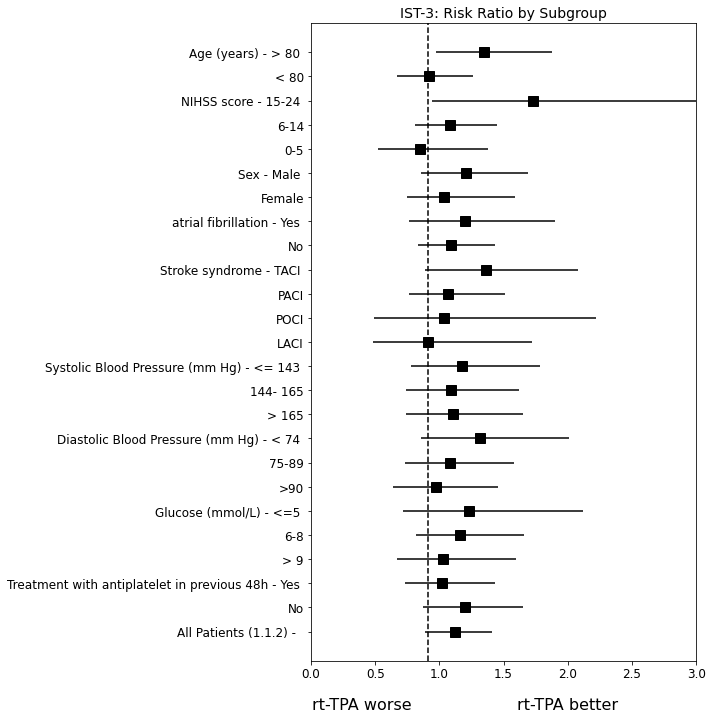

In [127]:
import matplotlib.pyplot as plt

# Data
data = [
    ["", 1.12, 0.89, 1.41,"All Patients (1.1.2)"],

    ["No", 1.20, 0.87,1.65, "Treatment with antiplatelet in previous 48h"],
    ["Yes",1.02, 0.73,1.43, "Treatment with antiplatelet in previous 48h"],

    ['> 9', 1.03, 0.67, 1.60,"Glucose (mmol/L)"],
     ['6-8', 1.16, 0.82, 1.66,"Glucose (mmol/L)"],
     ['<=5', 1.23, 0.72, 2.12,"Glucose (mmol/L)"],

     ['>90', 0.97, 0.64, 1.46,"Diastolic Blood Pressure (mm Hg)"],
     ['75-89', 1.08, 0.73, 1.58,"Diastolic Blood Pressure (mm Hg)"],
      ['< 74', 1.32, 0.86, 2.01,"Diastolic Blood Pressure (mm Hg)"],

      ['> 165', 1.11, 0.74, 1.65,"Systolic Blood Pressure (mm Hg)"],
     ['144- 165', 1.09, 0.74, 1.62,"Systolic Blood Pressure (mm Hg)"],
     ['<= 143', 1.18, 0.78, 1.78,"Systolic Blood Pressure (mm Hg)"],
    
      ['LACI', 0.91, 0.48, 1.72,"Stroke syndrome"],
      ['POCI', 1.04, 0.49, 2.22,"Stroke syndrome"],
      ['PACI', 1.07, 0.76, 1.51,"Stroke syndrome"],
      ['TACI', 1.36, 0.89, 2.08,"Stroke syndrome"],
    
     ['No', 1.09, 0.83, 1.43,"atrial fibrillation"],
     ['Yes', 1.20, 0.76, 1.90,"atrial fibrillation"],

     ['Female', 1.04, 0.75, 1.59,"Sex"],
     ['Male',1.21, 0.86, 1.69, "Sex"],

     ['0-5', 0.85, 0.52, 1.38, 'NIHSS score'],
     ['6-14', 1.08, 0.81, 1.45, 'NIHSS score'],
     ['15-24',1.73, 0.94, 3.20, 'NIHSS score'],
     # ['>25',7.43, 0.43, 12.9, 'NIHSS score'],
    
     # ['>= 25',7.43, 0.43, 12.9, 'NIHSS'],
    
     ["< 80",0.92, 0.67, 1.26 , "Age (years)"],
     ["> 80", 1.35, 0.97, 1.88 , "Age (years)"]
]

labels, medians, mins, maxs, categories = zip(*data)

# Compute the errors

lower_err = [median - min_ for median, min_ in zip(medians, mins)]
upper_err = [max_ - median for max_, median in zip(maxs, medians)]
errors = [lower_err, upper_err]

fig, ax = plt.subplots(figsize=(10,10))

# Plotting
y_range = range(len(labels))

# Reversing order
y_range = y_range[::-1]
medians = medians[::-1]
errors = [errors[0][::-1], errors[1][::-1]]

plt.errorbar(medians, y_range, xerr=errors, fmt='s', color="black", markersize=10)

# Set labels with category after range
new_labels = []
last_category = None
for label, min_, max_, category in reversed(list(zip(labels, mins, maxs, categories))):
    if category != last_category:
        new_labels.append(f'{category} - {label} ')
        last_category = category
    else:
        new_labels.append(f'{label}')

ax.set_yticks(y_range)
ax.set_yticklabels(new_labels, fontsize=12) # Larger font size here

ax.tick_params(axis='x', labelsize=12) # Larger font size for x-axis ticks

# Add custom text to the x-axis
ax.text(0.4, -3.2, "rt-TPA worse", color="black", ha="center", fontsize=16) # Larger font size here
ax.text(2.0, -3.2, "rt-TPA better", color="black", ha="center", fontsize=16) # Larger font size here

# Add a vertical dashed line at x = 0.91
ax.axvline(0.91, color='black', linestyle='--')
ax.set_xlim(0, 3)


plt.title("IST-3: Risk Ratio by Subgroup", size=14)
plt.tight_layout()
plt.show()

In [72]:
ist3 = pd.read_sas("data/datashare_aug2015.sas7bdat")

continuous_vars = [
    "age",
    "weight",
    "glucose",
    # "gcs_eye_rand",
    # "gcs_motor_rand",
    # "gcs_verbal_rand",
    "gcs_score_rand",
    "nihss" ,
    "sbprand",
    "dbprand"
]

cate_variables = [
    "infarct",
    "stroketype"
]

binary_vars = [
    "gender",
    "antiplat_rand",
    "atrialfib_rand"
]


outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]


x = ist3[continuous_vars + binary_vars +  cate_variables + treatment]

x[continuous_vars] = normalize_data(x[continuous_vars])

x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
x["gender"] = np.where(x["gender"]== 2, 1, 0)

feature_names = x.drop(treatment, axis=1).columns

n_categories = [x[i].nunique() if i in cate_variables else 1 for i in feature_names]

print(n_categories)

x = pd.get_dummies(x, columns=cate_variables)
n, feature_size = x.shape

feature_names_v2 = x.drop(treatment, axis=1).columns

treatment_index = x.columns.get_loc("itt_treat")

var_index = [i for i in range(feature_size) if i != treatment_index]


## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x)
x_train_scaled = imp.transform(x)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=42,
                                    )

# x_train, x_val, y_train, y_val = model_selection.train_test_split(
#                                             x_train,
#                                             y_train,
#                                             test_size=0.2,
#                                             random_state=42,
#                                     )

w_train = x_train[:, treatment_index] == 0
w_test =  x_test[:, treatment_index] == 0

x_train = x_train[:, var_index]
x_test = x_test[:, var_index]

y_train = y_train == 1
y_test = y_test == 1

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [20]:
model = pseudo_outcome_nets.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

model.fit(x_train, y_train, w_train)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7775177955627441, train_loss: 0.7467337250709534
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5251023769378662, train_loss: 0.4913491904735565
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.49964994192123413, train_loss: 0.42840060591697693
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.489416241645813, train_loss: 0.3923247158527374
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.4900873601436615, train_loss: 0.38729262351989746
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7380360960960388, train_loss: 0.7461926937103271
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5743824243545532, train_loss: 0.5587196946144104
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5466246008872986, train_loss: 0.5087816119194031
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.535206794

XLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=18, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=18, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimato

In [69]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

baseline_shapley_value_sampling_model = ShapleyValueSampling(model)

baseline_shapley_value = baseline_shapley_value_sampling_model.attribute(
                torch.tensor(baseline),
                n_samples=1000,
                perturbations_per_eval=10,
                baselines = torch.tensor(np.mean(baseline, axis=0).reshape(1,-1)),
                # baselines = torch.tensor(baseline),
                show_progress=True
).detach().cpu().numpy()

Shapley Value Sampling attribution: 100%|███| 2001/2001 [01:08<00:00, 29.28it/s]


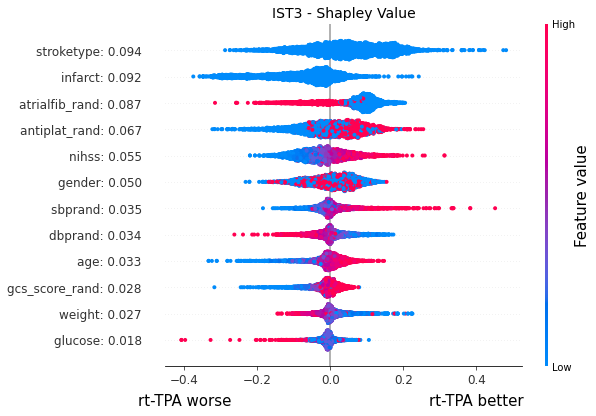

In [70]:
plot_feature_values(baseline_shapley_value, baseline, n_categories)

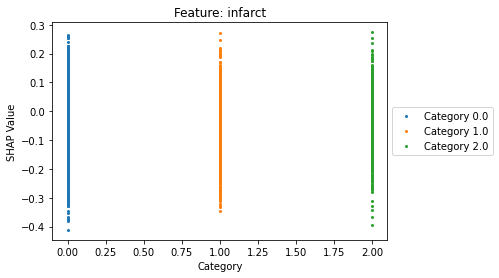

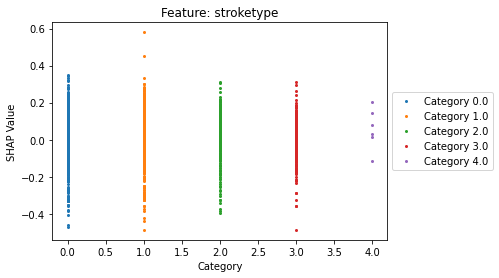

In [71]:
plot_categorical_feature_values(marginal_shapley_value, baseline, n_categories)

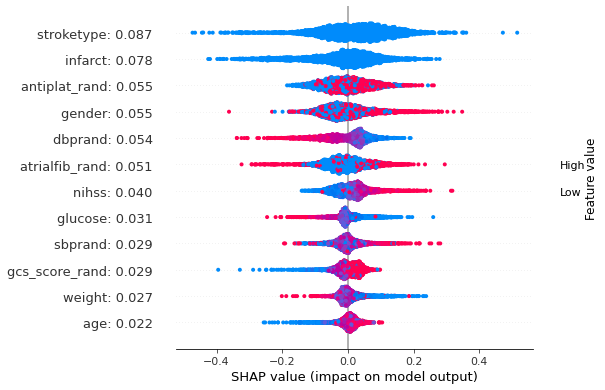

In [6]:
plot_feature_values(baseline_shapley_value, baseline, n_categories)

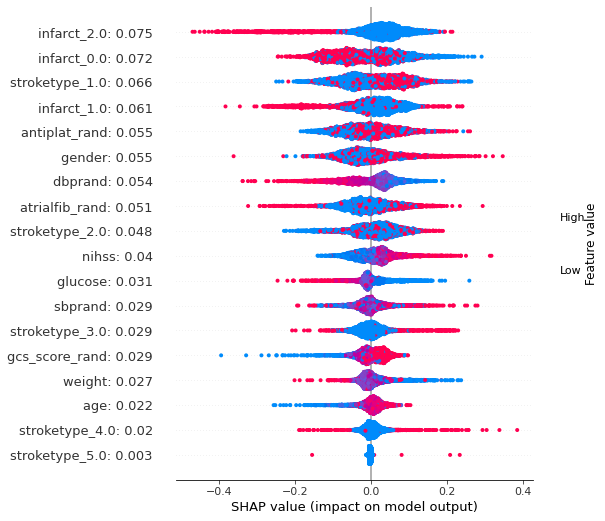

In [7]:
plot_feature_values_original(baseline_shapley_value, baseline)

Shapley Value Sampling attribution: 100%|█| 18001/18001 [01:01<00:00, 291.47it/s


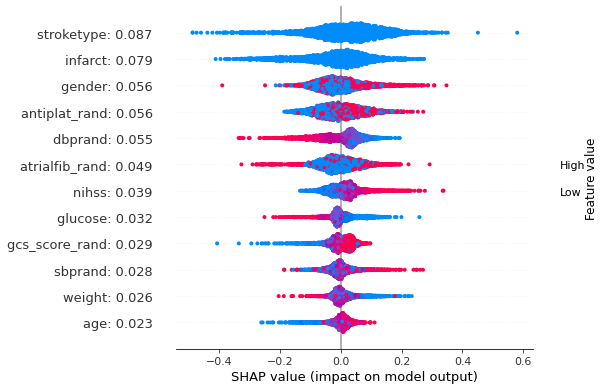

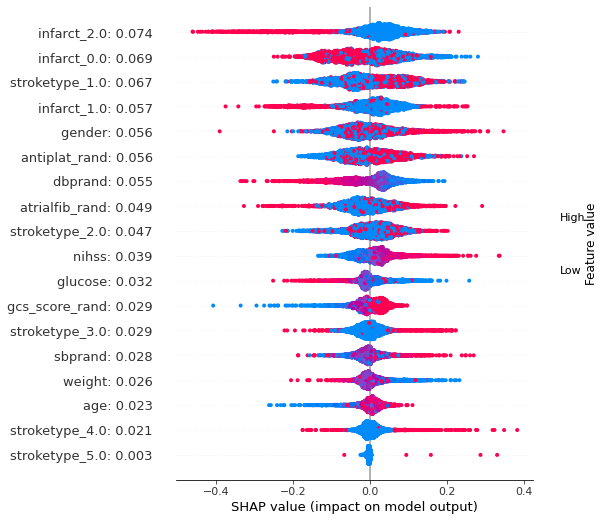

In [8]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

marginal_shapley_value = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(baseline),
                n_samples=1000,
                baselines = torch.tensor(np.mean(baseline, axis=0).reshape(1,-1)),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(marginal_shapley_value, baseline, n_categories)
plot_feature_values_original(marginal_shapley_value, baseline)

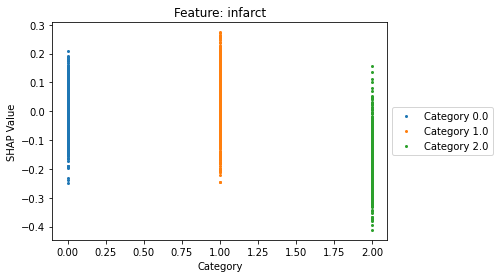

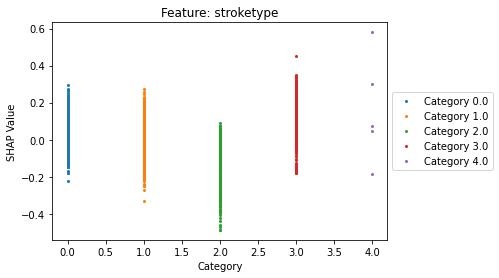

In [11]:
plot_categorical_feature_values(marginal_shapley_value, baseline, n_categories)

Permutation explainer: 3036it [01:48, 25.90it/s]                                


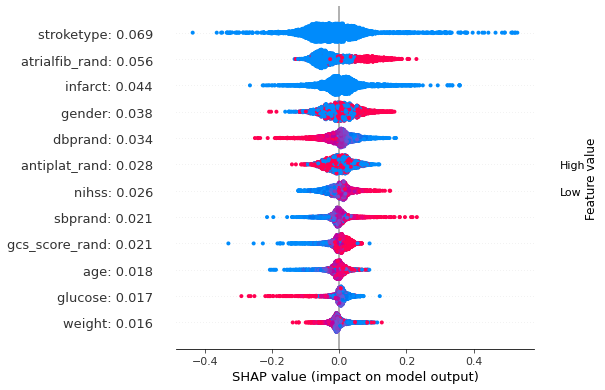

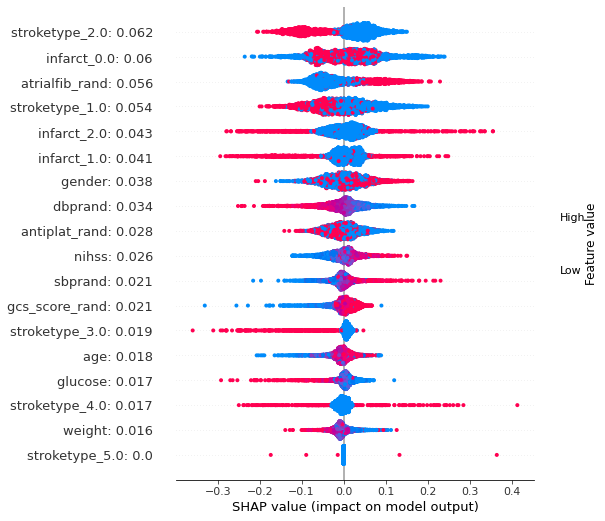

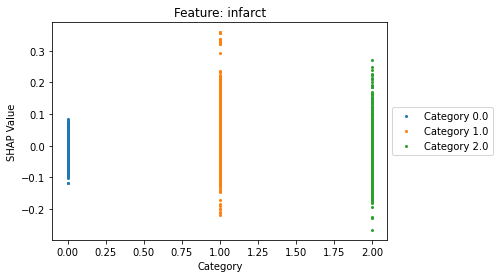

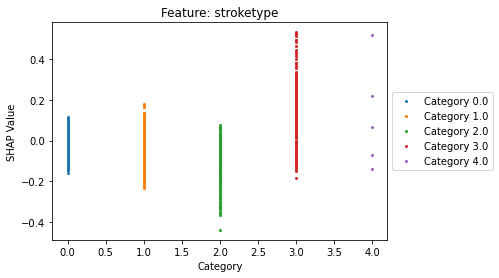

In [9]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_feature_values_original(shap_values.values, baseline)

plot_categorical_feature_values(shap_values.values, baseline, n_categories)

In [10]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

explainer = shap.explainers.Sampling(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_feature_values_original(shap_values.values, baseline)

plot_categorical_feature_values(shap_values.values, baseline, n_categories)

  3%|█                                      | 81/3035 [01:43<1:02:52,  1.28s/it]


KeyboardInterrupt: 

[po_est_impute_unconditional_mean] Epoch: 0, current validation loss: 0.6138721704483032, train_loss: 0.6458441019058228
[po_est_impute_unconditional_mean] Epoch: 50, current validation loss: 0.45374795794487, train_loss: 0.48837146162986755
[po_est_impute_unconditional_mean] Epoch: 100, current validation loss: 0.43283316493034363, train_loss: 0.44245123863220215
[po_est_impute_unconditional_mean] Epoch: 150, current validation loss: 0.42693275213241577, train_loss: 0.41558700799942017
[po_est_impute_unconditional_mean] Epoch: 200, current validation loss: 0.4265056550502777, train_loss: 0.41207605600357056
[po_est_impute_unconditional_mean] Epoch: 0, current validation loss: 0.6819400787353516, train_loss: 0.6906774640083313
[po_est_impute_unconditional_mean] Epoch: 50, current validation loss: 0.5722461342811584, train_loss: 0.5007331371307373
[po_est_impute_unconditional_mean] Epoch: 100, current validation loss: 0.5673696994781494, train_loss: 0.4491886496543884
[po_est_impute_unc

Permutation explainer: 3036it [00:49, 48.75it/s]                                


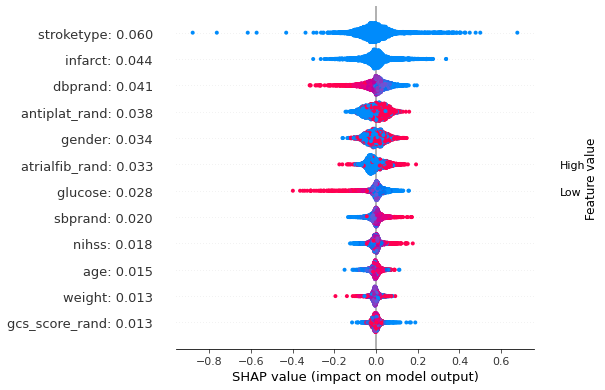

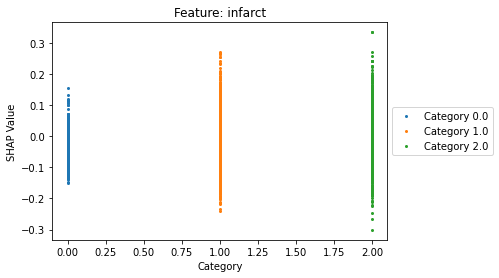

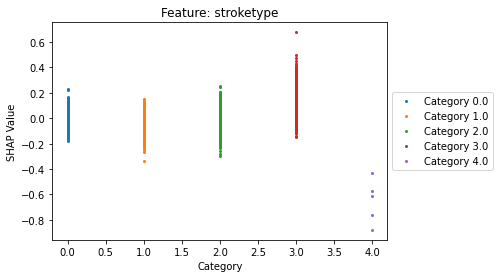

In [72]:
model = pseudo_outcome_nets.RLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

learner_explanations = {}

# learner_explanations["shapley_sampling"] = np.zeros((x_test.shape))
# marginal_extension = removal.MarginalExtension(x_test, model)

# for test_ind in range(len(x_test)):
#     instance = x_test[test_ind]
#     game = games.PredictionGame(marginal_extension, instance)
#     explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
#     learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, x_test.shape[1])

# plot_feature_values(learner_explanations["shapley_sampling"])

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.9554045796394348, train_loss: 0.9926087260246277
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5899448990821838, train_loss: 0.5736987590789795
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5009039640426636, train_loss: 0.44446292519569397
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.480671226978302, train_loss: 0.38867247104644775
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.47752100229263306, train_loss: 0.3484068810939789
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6873695254325867, train_loss: 0.7140087485313416
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5291489362716675, train_loss: 0.5072386860847473
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5072816014289856, train_loss: 0.4401850402355194
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.503801047

Permutation explainer: 3036it [00:49, 48.50it/s]                                


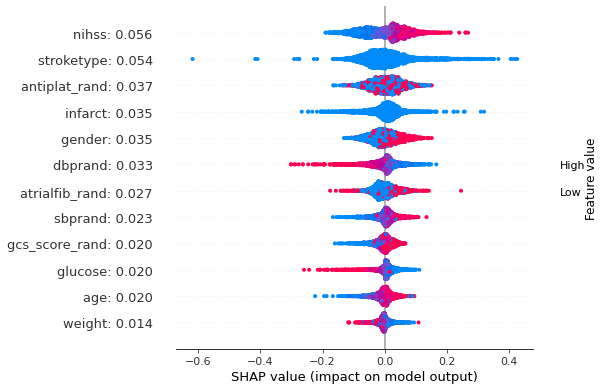

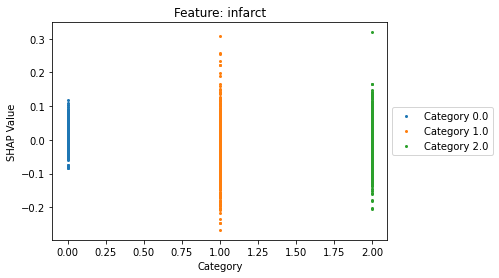

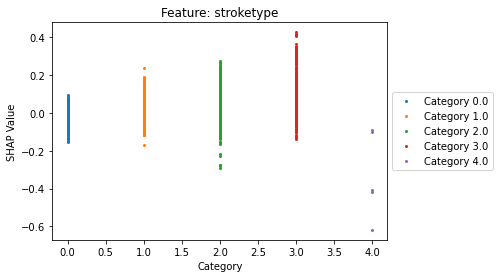

In [73]:
model = pseudo_outcome_nets.RALearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[TARNet] Epoch: 0, current validation loss: 0.6893719434738159 train_loss: 0.6900596022605896
[TARNet] Epoch: 50, current validation loss: 0.6488354206085205 train_loss: 0.64727783203125
[TARNet] Epoch: 100, current validation loss: 0.5971236228942871 train_loss: 0.588253915309906
[TARNet] Epoch: 150, current validation loss: 0.5569208264350891 train_loss: 0.5351617932319641
[TARNet] Epoch: 200, current validation loss: 0.5440869927406311 train_loss: 0.5155655145645142
[TARNet] Epoch: 250, current validation loss: 0.537254810333252 train_loss: 0.5045313835144043
[TARNet] Epoch: 300, current validation loss: 0.5317315459251404 train_loss: 0.4943632483482361
[TARNet] Epoch: 350, current validation loss: 0.5270311832427979 train_loss: 0.4881545603275299
[TARNet] Epoch: 400, current validation loss: 0.5236188173294067 train_loss: 0.4803340435028076
[TARNet] Epoch: 450, current validation loss: 0.521166205406189 train_loss: 0.47150352597236633
[TARNet] Epoch: 500, current validation loss: 0

Permutation explainer: 3036it [01:29, 29.92it/s]                                


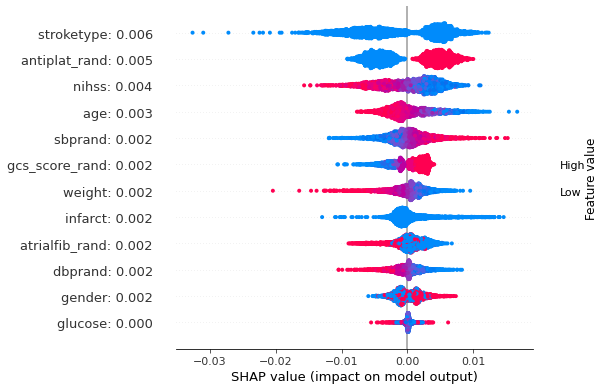

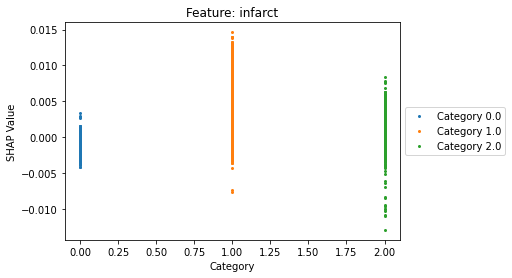

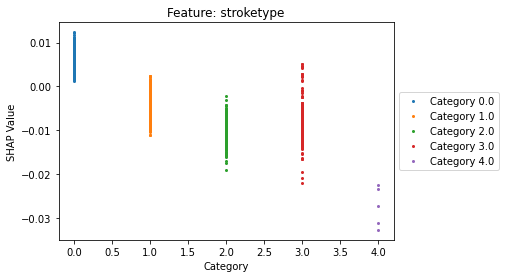

In [74]:
model = cate_models.torch.TARNet(
            x_train.shape[1],
            binary_y=(len(np.unique(y_train)) == 2),
            n_layers_r=2,
            n_layers_out=2,
            n_units_out=100,
            n_units_r=100,
            batch_size=128,
            n_iter=1000,
            lr=1e-5,
            batch_norm=False,
            early_stopping = True,
            nonlin="relu",
        )

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[DragonNet] Epoch: 0, current validation loss: 1.3849462270736694 train_loss: 1.385475754737854
[DragonNet] Epoch: 50, current validation loss: 1.3019402027130127 train_loss: 1.2929776906967163
[DragonNet] Epoch: 100, current validation loss: 1.240375280380249 train_loss: 1.2152279615402222
[DragonNet] Epoch: 150, current validation loss: 1.2227540016174316 train_loss: 1.1884409189224243
[DragonNet] Epoch: 200, current validation loss: 1.2129709720611572 train_loss: 1.1677701473236084
[DragonNet] Epoch: 250, current validation loss: 1.2092010974884033 train_loss: 1.1542671918869019


Permutation explainer: 3036it [02:32, 18.57it/s]                                


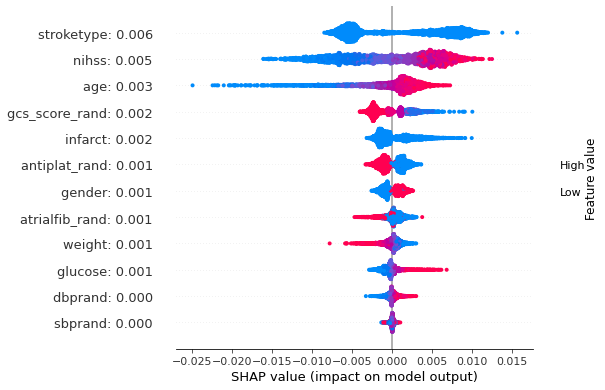

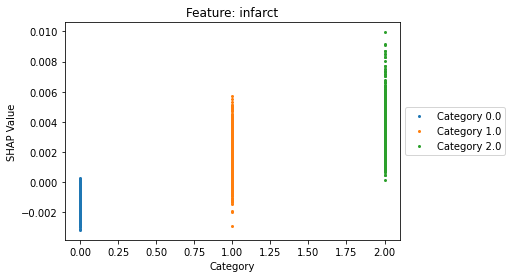

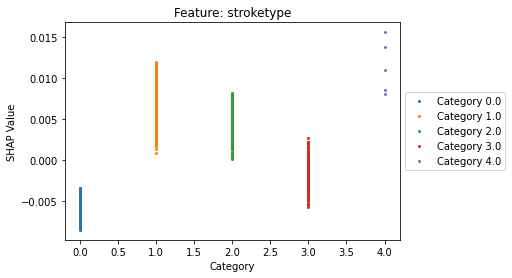

In [75]:
model = cate_models.torch.DragonNet(
            x_train.shape[1],
            binary_y=(len(np.unique(y_train)) == 2),
            batch_size=128,
            n_iter=1000,
            lr=1e-5,
            batch_norm=False,
            nonlin="relu",
        )

model.fit(x_train, y_train, w_train)

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[slearner_po_estimator] Epoch: 0, current validation loss: 0.7561942338943481, train_loss: 0.7621263265609741
[slearner_po_estimator] Epoch: 50, current validation loss: 0.4989801347255707, train_loss: 0.48219841718673706
[slearner_po_estimator] Epoch: 100, current validation loss: 0.4801802635192871, train_loss: 0.4397190809249878
[slearner_po_estimator] Epoch: 150, current validation loss: 0.4787187874317169, train_loss: 0.4239770770072937
[slearner_po_estimator] Epoch: 200, current validation loss: 0.4785993695259094, train_loss: 0.4225805401802063


Permutation explainer: 3036it [01:28, 30.19it/s]                                


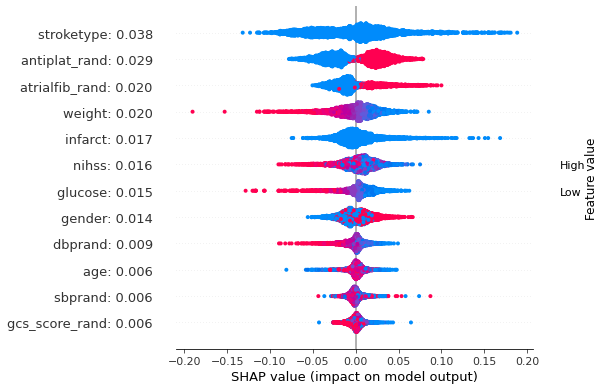

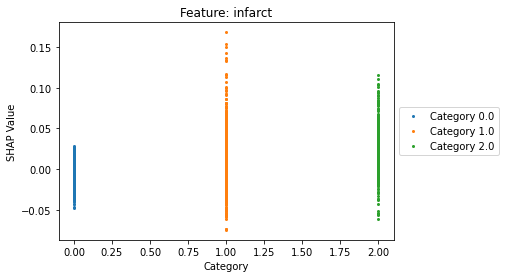

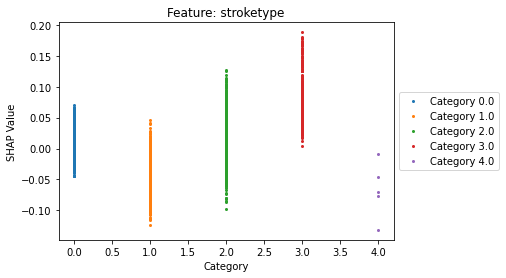

In [76]:
model = cate_models.torch.SLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

In [ ]:
model = cate_models.torch.TLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, np.concatenate([x_train, x_test], axis=0))
shap_values = explainer(np.concatenate([x_train, x_test], axis=0))
plot_feature_values(shap_values.values, np.concatenate([x_train, x_test], axis=0), n_categories)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7552102208137512, train_loss: 0.7444889545440674
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5285875201225281, train_loss: 0.4970513582229614
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.4879630506038666, train_loss: 0.43373599648475647
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.4751794934272766, train_loss: 0.38654184341430664
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.4693801999092102, train_loss: 0.3650873601436615
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6363965272903442, train_loss: 0.669018566608429
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5158784985542297, train_loss: 0.4900670349597931
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5132080912590027, train_loss: 0.4525911509990692
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.5134476423

Permutation explainer: 2550it [02:23, 16.44it/s]                                


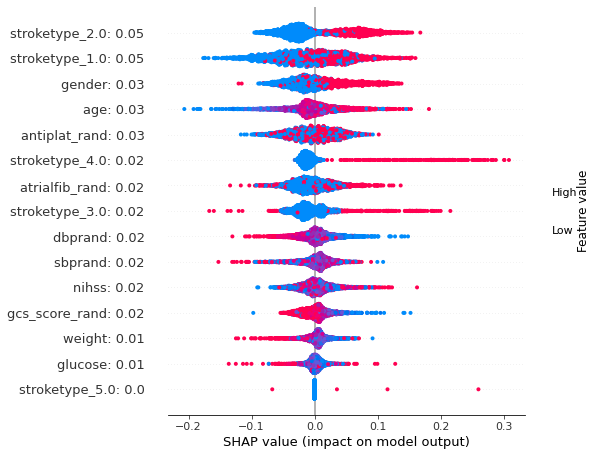

In [110]:
model = cate_models.torch.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, np.concatenate([x_train, x_test], axis=0))
shap_values = explainer(np.concatenate([x_train, x_test], axis=0))
plot_feature_values(shap_values.values, np.concatenate([x_train, x_test], axis=0))

average tx effect 0.0062297457
average tx effect 0.00623464


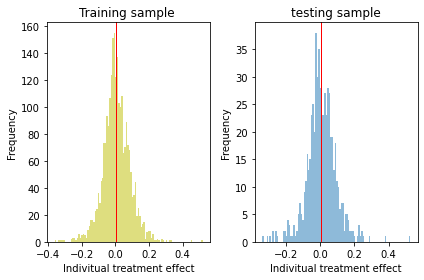

In [53]:
import matplotlib.pyplot as plt 

train_output = model(x_train).detach().cpu().numpy()
test_output = model(x_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(train_output), linewidth=1, color='r')

plt.title("Training sample " )
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output,bins=100 , alpha = 0.5)
plt.axvline(x= np.mean(test_output), linewidth=1, color='r')

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

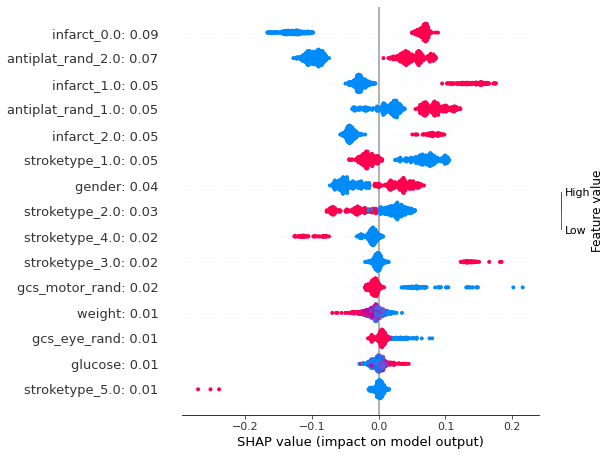

In [54]:
plot_feature_values(learner_explanations["shapley_sampling"])

In [ ]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)

learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

In [ ]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])

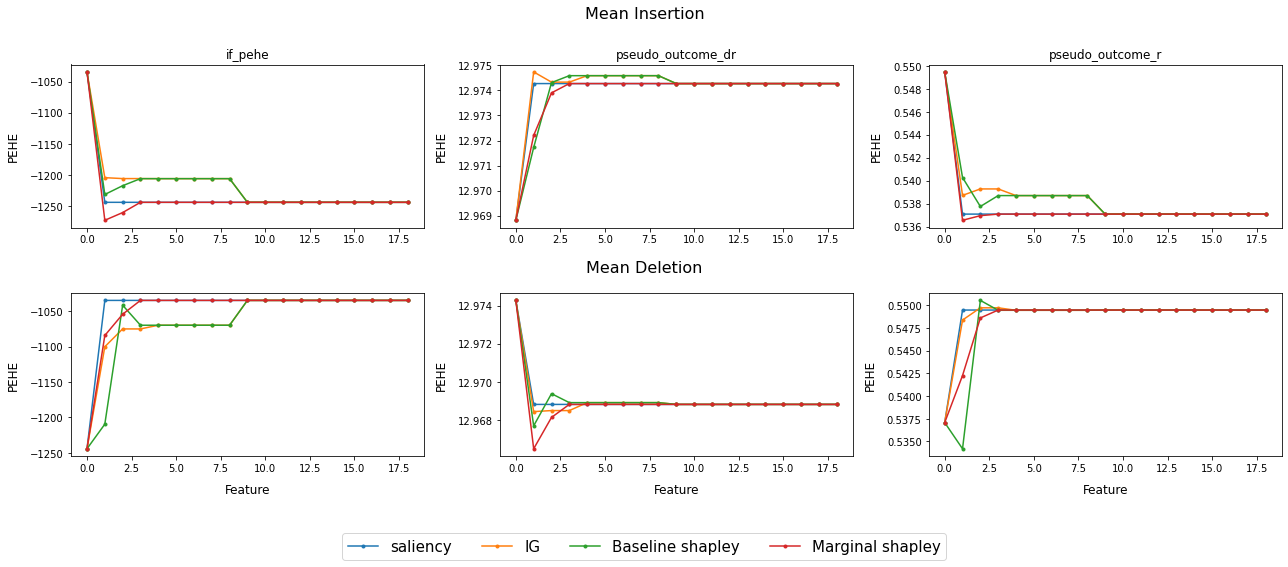

In [147]:
import pickle as pkl
import matplotlib.gridspec as gridspec


learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

# Loop over the different files

seeds = [0, 1, 2,3, 4]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"results/ist3/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])
            auroc_ate[exp].append(results[exp_index][4])
            
            auroc_full.append(results[exp_index][7])
            auroc_full_ate.append(results[exp_index][6])
            
            auroc_random.append(results[exp_index][9])
            auroc_random_ate.append(results[exp_index][8])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


# # Function to calculate the percentage contribution of cumulative PEHE up to nth feature relative to the total PEHE at final feature
# def calc_cumulative_contribution(n, data):
#     if n >= len(data):
#         raise ValueError(f"Feature index {n} is out of bounds for data of length {len(data)}")
#     percentage_contribution = (data[-1] - data[n] / data[-1]) * 100
#     return percentage_contribution

# # Let's say you want the cumulative contribution of PEHE when up to the 5th feature is added
# n = 4

# # Loop through each explainer and selection type
# for exp in explainers:
#     for selection_type in selection_types:
#         # Get the cumulative PEHE for each feature
#         pehe_values = np.mean(insertion_results_all[exp][selection_type], axis=0)
#         percentage_contribution = calc_cumulative_contribution(n, pehe_values)
        
#         # Print the percentage contribution of PEHE up to nth feature
#         print(f"For {exp} with {selection_type} selection:")
#         print(f"Percentage contribution of PEHE up to {n+1}th feature: {percentage_contribution}%")


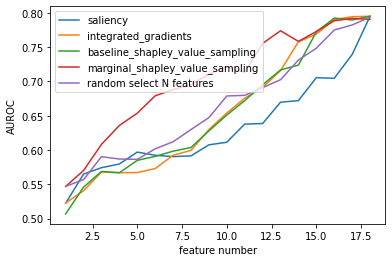

In [140]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}


for k, v in auroc_results.items():
    
    feature_num = [i+1 for i in range(v.shape[0])]
    plt.plot(feature_num, v, label = k)

plt.plot([i+1 for i in range(18)], np.array(auroc_random).mean(axis=0), label="random select N features")

plt.xlabel("feature number")
plt.ylabel("AUROC")
plt.legend()


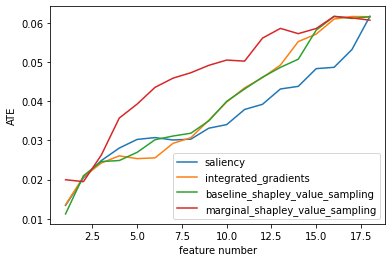

In [141]:
auroc_results_ate = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}

for k, v in auroc_results_ate.items():
    
    feature_num = [i+1 for i in range(v.shape[0])]
    plt.plot(feature_num, v, label = k)

# plt.plot([i+1 for i in range(18)], np.array(auroc_random_ate).mean(axis=0), label="random select N features")

plt.xlabel("feature number")
plt.ylabel("ATE")
plt.legend()

In [33]:
np.mean(auroc_full), np.mean(auroc_full_ate)

(0.8066334288427657, 0.06087872475336568)

In [34]:
np.mean(auroc_random) ,np.mean(auroc_random_ate)

(0.589805329934426, 0.02520123749627706)